# 1.Import Necessary Libraries

In [3]:
# Install required libraries if not already installed
!pip install imbalanced-learn xgboost scikeras[tensorflow] tensorflow keras-tuner

# Import libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import keras_tuner as kt

# Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Save models
import joblib

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.0 MB/s eta 0:00:00


# 2.Load and Inspect the Dataset

In [4]:
# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import pandas as pd
import numpy as np

# Load the dataset
file_path = '/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/Asteroid Collision Dataset V2.csv'
df = pd.read_csv(file_path, low_memory=False)

# Inspect the dataset
print("Dataset Shape:", df.shape)
print("First 5 Rows:\n", df.head())


Mounted at /content/drive
Dataset Shape: (677494, 79)
First 5 Rows:
    diameter  extent  albedo  rot_per  GM  BV  UB  IR spec_B  spec_T  ...  \
0       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
1       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
2       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
3       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   
4       NaN     NaN     NaN      NaN NaN NaN NaN NaN    NaN     NaN  ...   

        rms  two_body  A1  A1_sigma  A2  A2_sigma  A3  A3_sigma  DT  DT_sigma  
0  0.000533       NaN NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
1  0.071263       NaN NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
2  0.000002       NaN NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
3       NaN         T NaN       NaN NaN       NaN NaN       NaN NaN       NaN  
4  0.339380       NaN NaN       NaN NaN       NaN NaN       NaN NaN       

# 3.Initial EDA


--- Initial EDA (Before Preprocessing) ---

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677494 entries, 0 to 677493
Data columns (total 79 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   diameter        6866 non-null    float64
 1   extent          0 non-null       float64
 2   albedo          6500 non-null    float64
 3   rot_per         1347 non-null    float64
 4   GM              0 non-null       float64
 5   BV              0 non-null       float64
 6   UB              0 non-null       float64
 7   IR              0 non-null       float64
 8   spec_B          50 non-null      object 
 9   spec_T          0 non-null       float64
 10  full_name       677494 non-null  object 
 11  a               677494 non-null  float64
 12  e               677494 non-null  float64
 13  i               677494 non-null  float64
 14  om              677494 non-null  float64
 15  w               677494 non-null  float64


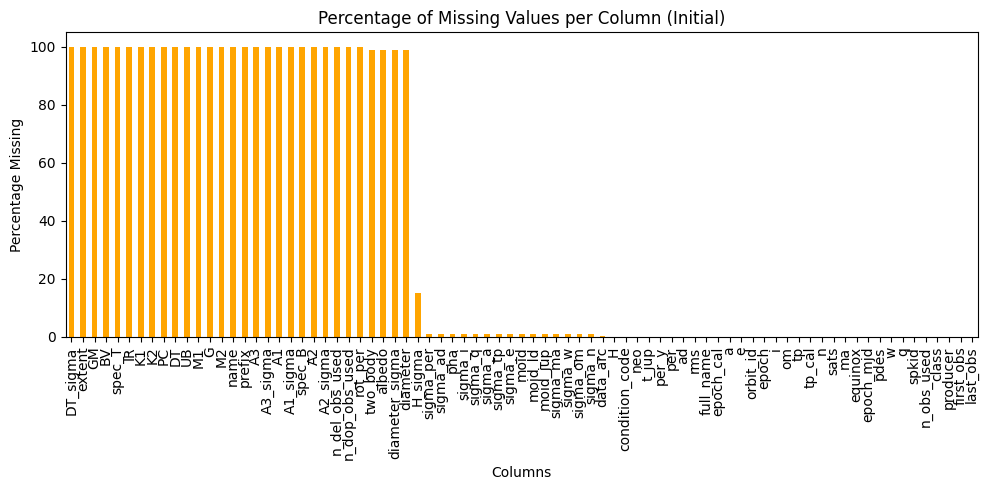

In [5]:
print("\n--- Initial EDA (Before Preprocessing) ---")
# Basic Info
print("\nDataframe Info:")
df.info()

# Statistical Summary
print("\nStatistical Summary of Numeric Columns:")
print(df.describe(include=[np.number]))

# Check missing values again visually
missing_summary = df.isnull().mean().sort_values(ascending=False)*100
print("\nMissing Data Summary (Percentage of Missing Values):\n", missing_summary)

# Plot Missing Values
plt.figure(figsize=(10,5))
missing_summary.plot(kind='bar', color='orange')
plt.title('Percentage of Missing Values per Column (Initial)')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.tight_layout()
plt.show()

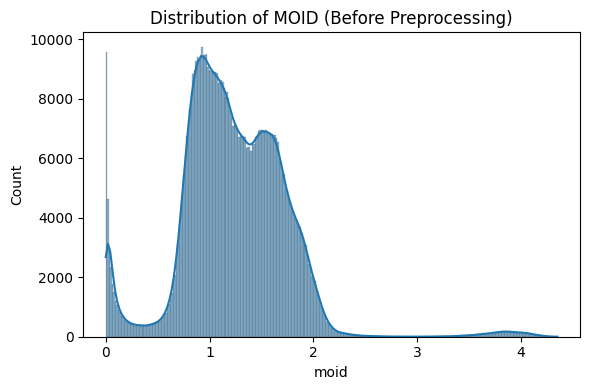

In [7]:
# Distribution of MOID (Before Preprocessing)
if 'moid' in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df['moid'], kde=True)
    plt.title('Distribution of MOID (Before Preprocessing)')
    plt.tight_layout()
    plt.show()

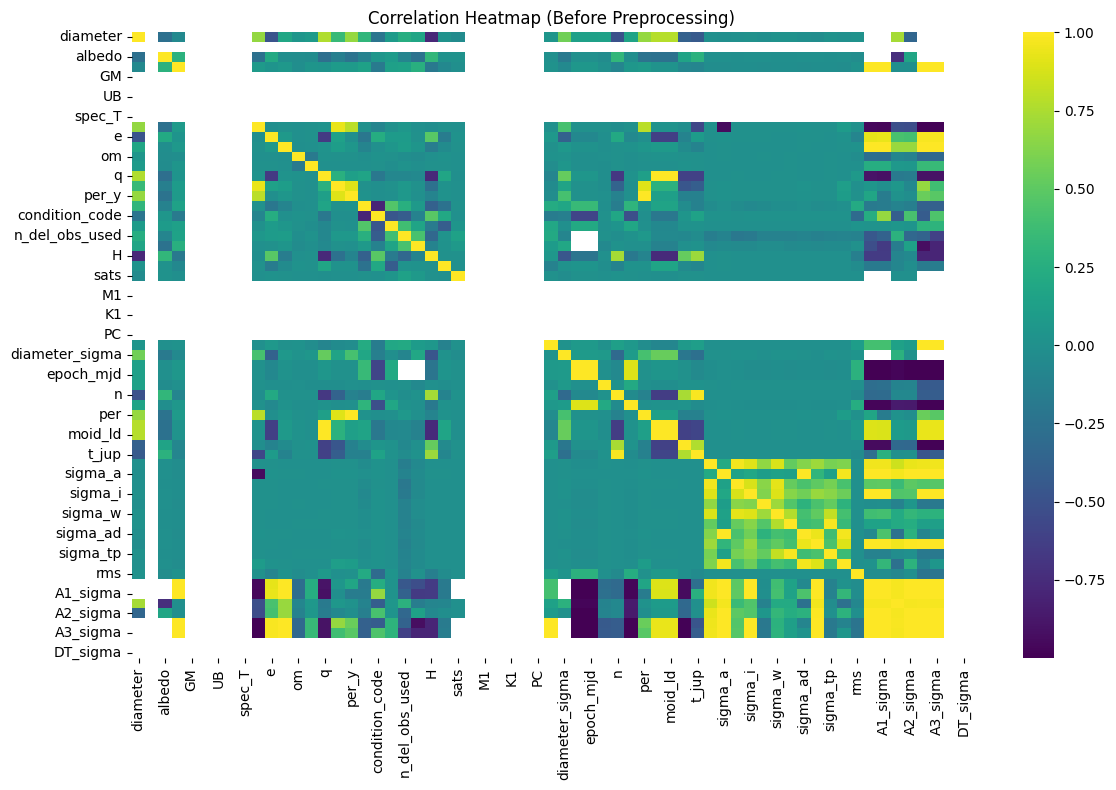

In [8]:
# Correlation Heatmap (Initial)
numeric_cols_initial = df.select_dtypes(include=[np.number]).columns
corr_initial = df[numeric_cols_initial].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_initial, annot=False, cmap='viridis')
plt.title('Correlation Heatmap (Before Preprocessing)')
plt.tight_layout()
plt.show()

# 4.Data Preprocessing

## 4.1. Handle Missing Data

In [9]:
# Analyze missing data
missing_summary = df.isnull().mean().sort_values(ascending=False) * 100
missing_summary = missing_summary[missing_summary > 0]
print("\nMissing Data Summary (Percentage of Missing Values):")
print(missing_summary)

# Drop columns with >90% missing values or irrelevant
cols_to_drop_missing = missing_summary[missing_summary > 90].index.tolist()
irrelevant_columns = ['producer', 'equinox', 'orbit_id', 'pdes', 'full_name', 'name', 'prefix']
cols_to_drop = list(set(cols_to_drop_missing + irrelevant_columns))

cols_to_drop = [col for col in cols_to_drop if col in df.columns]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print("\nDropped Columns:")
print(cols_to_drop)


Missing Data Summary (Percentage of Missing Values):
DT_sigma          100.000000
extent            100.000000
GM                100.000000
BV                100.000000
spec_T            100.000000
IR                100.000000
K1                100.000000
K2                100.000000
PC                100.000000
DT                100.000000
UB                100.000000
M1                100.000000
G                 100.000000
M2                100.000000
name               99.999852
prefix             99.999410
A3                 99.998967
A3_sigma           99.998967
A1                 99.997491
A1_sigma           99.997491
spec_B             99.992620
A2                 99.976531
A2_sigma           99.976531
n_del_obs_used     99.910700
n_dop_obs_used     99.910700
rot_per            99.801179
two_body           99.062427
albedo             99.040582
diameter_sigma     98.987002
diameter           98.986559
H_sigma            15.064635
sigma_per           0.937868
sigma_ad          

## 4.2. Impute missing values in numeric columns

In [10]:
# Impute missing values in numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

## 4.3. Map Binary Columns

In [11]:
# Map 'Y'/'N' to 1/0 in binary columns
binary_mapping = {'Y': 1, 'N': 0}
for col in ['neo', 'pha']:
    if col in df.columns:
        df[col] = df[col].map(binary_mapping)

## 4.4. Handle Date Columns

In [12]:
# Convert date columns to datetime and extract year, month, day
date_cols = ['epoch_cal', 'tp_cal', 'first_obs', 'last_obs']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', format='%Y-%m-%d')
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df.drop(columns=[col], inplace=True)

In [13]:
df.shape

(677494, 52)

## 4.5. One-Hot Encode Categorical Columns

In [14]:
# Identify remaining categorical columns
remaining_categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nRemaining Categorical Columns after Date conversion:", remaining_categorical_cols)

# One-hot encode the 'class' column if it exists
if 'class' in df.columns:
    df = pd.get_dummies(df, columns=['class'], prefix='class', drop_first=True)


Remaining Categorical Columns after Date conversion: ['class']


# 5.Feature Engineering

## 5.1. Add Derived Features

In [15]:
GRAVITATIONAL_CONSTANT = 39.478  # AU^3 / yr^2

# Add derived features
df['relative_orbital_distance'] = np.abs(df['q'] - df['a'] * (1 - df['e']))
df['orbital_velocity'] = np.sqrt(GRAVITATIONAL_CONSTANT / df['a'])
df['adjusted_eccentricity'] = df['e'] * df['a'] / df['q']

## 5.2. Add Perturbed Features

In [16]:
# Perturb orbital elements based on their uncertainties
for col in ['a', 'e', 'q', 'i']:
    sigma_col = f'sigma_{col}'
    if sigma_col in df.columns:
        df[f'{col}_perturbed'] = df[col] + np.random.normal(0, df[sigma_col])

## 5.3. Create Target Variable

In [17]:
# Create 'collision_risk' based on 'moid' (Minimum Orbit Intersection Distance)
df['collision_risk'] = np.where(df['moid'] < 0.05, 1, 0)

# Drop 'moid' and 'moid_ld' from features
features_to_drop = ['moid', 'moid_ld']
df.drop(columns=features_to_drop, inplace=True, errors='ignore')

# 6.Prepare Data for Modeling

## 6.1. Define Features and Target

In [18]:
# Define features and target variable
X = df.drop(columns=['collision_risk'])
y = df['collision_risk']

# Ensure only numeric features are used
X = X.select_dtypes(include=[np.number])

## 6.2. Split the Dataset

In [19]:
# Split the dataset with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 6.3. Handle Missing Values in Training and Testing Sets

In [20]:
# Identify columns with all missing values and drop them
all_missing_cols = X_train.columns[X_train.isnull().all()]
print("Columns with all missing values:", all_missing_cols.tolist())

X_train.drop(columns=all_missing_cols, inplace=True)
X_test.drop(columns=all_missing_cols, inplace=True)

# Re-impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Verify no missing values remain
print("Missing Values in X_train:", X_train.isnull().sum().sum())
print("Missing Values in X_test:", X_test.isnull().sum().sum())

Columns with all missing values: ['epoch_cal_year', 'epoch_cal_month', 'epoch_cal_day', 'tp_cal_year', 'tp_cal_month', 'tp_cal_day']
Missing Values in X_train: 0
Missing Values in X_test: 0


## 6.4. Handle Class Imbalance with SMOTE

In [21]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled Training Set Shape:", X_train_resampled.shape)
print("Class Distribution After Resampling:\n", y_train_resampled.value_counts())

Resampled Training Set Shape: (1054508, 50)
Class Distribution After Resampling:
 collision_risk
0    527254
1    527254
Name: count, dtype: int64


In [22]:
print("Missing Values in the Entire Dataset:\n", df.isnull().sum())

Missing Values in the Entire Dataset:
 a                 0
e                 0
i                 0
om                0
w                 0
                 ..
a_perturbed       0
e_perturbed       0
q_perturbed       0
i_perturbed       0
collision_risk    0
Length: 66, dtype: int64


## 6.5. Data Scaling

In [23]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# 7.Secondary EDA


--- Secondary EDA (After Preprocessing) ---
Post-Preprocessing X_train_resampled_scaled shape: (1054508, 50)
Class Distribution in y_train_resampled:
 collision_risk
0    527254
1    527254
Name: count, dtype: int64


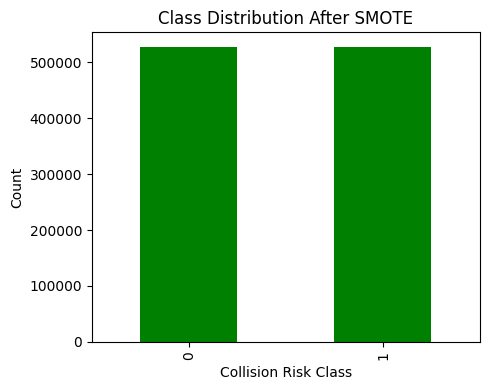

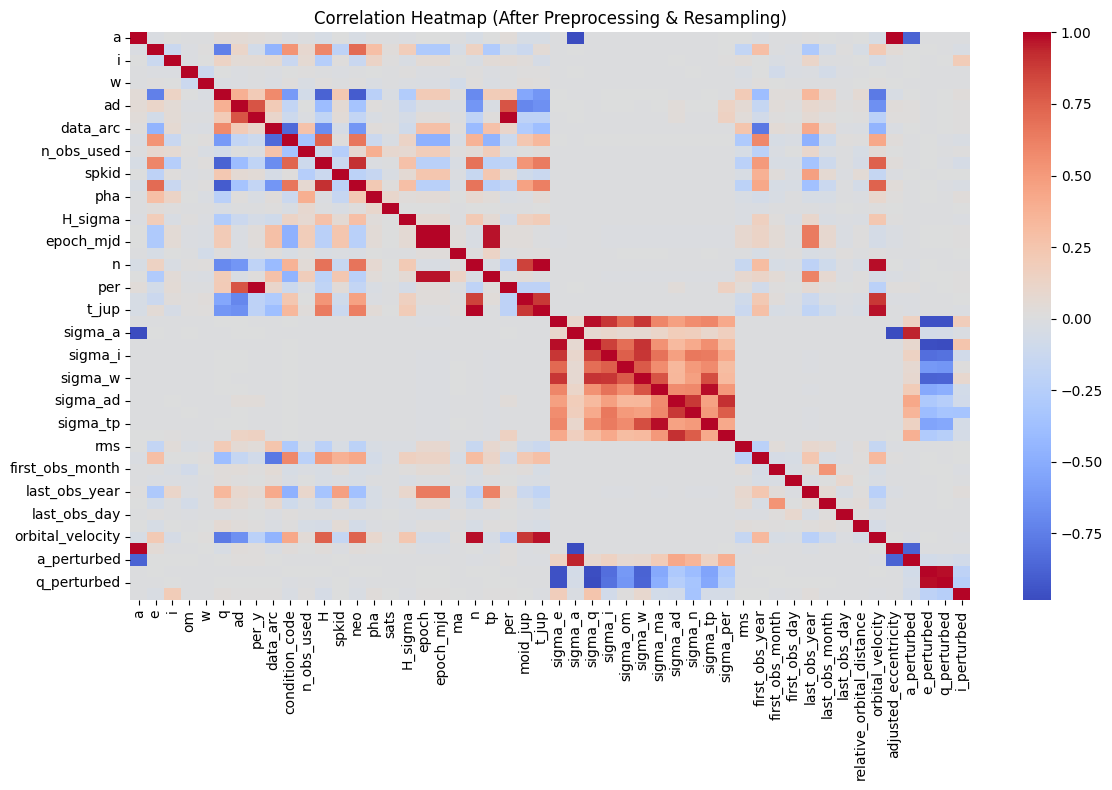

In [24]:
print("\n--- Secondary EDA (After Preprocessing) ---")

# Check the shape and distribution again
print("Post-Preprocessing X_train_resampled_scaled shape:", X_train_resampled_scaled.shape)
print("Class Distribution in y_train_resampled:\n", y_train_resampled.value_counts())

# Plot class distribution after SMOTE
plt.figure(figsize=(5,4))
y_train_resampled.value_counts().plot(kind='bar', color='green')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Collision Risk Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Correlation heatmap after preprocessing (use the X_train after imputation/dropping)
X_train_post = pd.DataFrame(X_train_resampled_scaled, columns=X_train.columns)
corr_post = pd.DataFrame(X_train_post, columns=X_train.columns).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_post, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (After Preprocessing & Resampling)')
plt.tight_layout()
plt.show()

# 8.Model Training and Evaluation

## 8.1 Random Forest Classifier

### 8.1.1. Initial Model Training

In [25]:
# Initialize the Random Forest model
rf_model_initial = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Train the initial model
rf_model_initial.fit(X_train_resampled_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_rf_initial = rf_model_initial.predict(X_test_scaled)

# Evaluate the initial model
print("Initial Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_initial, digits=4))

# Feature importance analysis
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model_initial.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("Top 10 Most Important Features (Initial Random Forest):")
print(feature_importance_rf.head(10))

Initial Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9955    0.9976    131814
           1     0.8609    0.9859    0.9192      3685

    accuracy                         0.9953    135499
   macro avg     0.9303    0.9907    0.9584    135499
weighted avg     0.9958    0.9953    0.9954    135499

Top 10 Most Important Features (Initial Random Forest):
                  Feature  Importance
5                       q    0.206626
13                    neo    0.169845
48            q_perturbed    0.160098
11                      H    0.085955
20                      n    0.050118
7                   per_y    0.046873
44       orbital_velocity    0.040982
46            a_perturbed    0.036019
45  adjusted_eccentricity    0.033287
22                    per    0.031851


### 8.1.2. Hyperparameter Tuning with HalvingRandomSearchCV

In [26]:
# Simplified parameter grid, including n_estimators
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

rf_model_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Initialize HalvingRandomSearchCV without specifying resource
halving_random_search_rf = HalvingRandomSearchCV(
    estimator=rf_model_base,
    param_distributions=param_grid_rf,
    factor=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

halving_random_search_rf.fit(X_train_resampled_scaled, y_train_resampled)

print("Best parameters found for Random Forest:")
print(halving_random_search_rf.best_params_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 16
min_resources_: 20
max_resources_: 1054508
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 20
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 4
n_resources: 40
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 80
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 3
n_candidates: 1
n_resources: 160
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found for Random Forest:
{'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20, 'class_weight': 'balanced'}


### 8.1.3. Evaluate the Tuned Random Forest Model

In [27]:
# Use the best estimator
best_rf_model = halving_random_search_rf.best_estimator_

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test_scaled)

# Evaluate the tuned model
print("Tuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))

print("Tuned Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Accuracy score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Tuned Random Forest Accuracy:", accuracy_rf)

Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9951    0.9974    131814
           1     0.8501    0.9910    0.9152      3685

    accuracy                         0.9950    135499
   macro avg     0.9249    0.9931    0.9563    135499
weighted avg     0.9957    0.9950    0.9952    135499

Tuned Random Forest Confusion Matrix:
[[131170    644]
 [    33   3652]]
Tuned Random Forest Accuracy: 0.9950036531634919


## 8.2 Gradient Boosting Classifier (XGBoost)

### 8.2.1. Initial Model Training

In [28]:
!pip install --upgrade xgboost

In [29]:
# Initialize the XGBoost model
xgb_model_initial = XGBClassifier(
    n_estimators=100,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the initial model
xgb_model_initial.fit(X_train_resampled_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_xgb_initial = xgb_model_initial.predict(X_test_scaled)

# Evaluate the initial model
print("Initial XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb_initial, digits=4))

# Feature importance analysis
feature_importance_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model_initial.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("Top 10 Most Important Features (Initial XGBoost):")
print(feature_importance_xgb.head(10))


Initial XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.9993    0.9973    0.9983    131814
           1     0.9102    0.9734    0.9407      3685

    accuracy                         0.9967    135499
   macro avg     0.9547    0.9854    0.9695    135499
weighted avg     0.9968    0.9967    0.9967    135499

Top 10 Most Important Features (Initial XGBoost):
                      Feature  Importance
5                           q    0.904322
48                q_perturbed    0.029083
14                        pha    0.021751
13                        neo    0.007378
11                          H    0.005321
43  relative_orbital_distance    0.003443
9              condition_code    0.002563
41             last_obs_month    0.001508
7                       per_y    0.001319
2                           i    0.001288


### 8.2.2 Hyperparameter Tuning with RandomizedSearchCV

In [30]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1]
}

# Initialize the base XGBoost model
xgb_model_base = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize RandomizedSearchCV without early stopping parameters
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model_base,
    param_distributions=param_grid_xgb,
    n_iter=10,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the model on the training data WITHOUT early stopping
random_search_xgb.fit(X_train_resampled_scaled, y_train_resampled)

# Print the best parameters found
print("Best parameters found for XGBoost:")
print(random_search_xgb.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found for XGBoost:
{'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


### 8.2.3 Evaluate the Tuned XGBoost Model

In [31]:

import xgboost as xgb
from xgboost.callback import EarlyStopping

# Convert data to DMatrix
dtrain = xgb.DMatrix(X_train_resampled_scaled, label=y_train_resampled)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

params = random_search_xgb.best_params_
params.update({
    'random_state': 42,
    'eval_metric': 'logloss'
})

# Early stopping callback
early_stopping_cb = EarlyStopping(rounds=10, save_best=True)

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=9999,
    evals=[(dtest, 'eval')],
    callbacks=[early_stopping_cb]
)

# Predict with the final model
y_pred_xgb = (xgb_model.predict(dtest) > 0.5).astype(int)

print("Tuned XGBoost Classification Report (with native train and callbacks):")
print(classification_report(y_test, y_pred_xgb, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))



[0]	eval-logloss:0.59899
[1]	eval-logloss:0.52134
[2]	eval-logloss:0.45639
[3]	eval-logloss:0.40146
[4]	eval-logloss:0.35456
[5]	eval-logloss:0.31422
[6]	eval-logloss:0.27934
[7]	eval-logloss:0.24902
[8]	eval-logloss:0.22252
[9]	eval-logloss:0.19932
[10]	eval-logloss:0.17895
[11]	eval-logloss:0.16100
[12]	eval-logloss:0.14517
[13]	eval-logloss:0.13116
[14]	eval-logloss:0.11876
[15]	eval-logloss:0.10777
[16]	eval-logloss:0.09805
[17]	eval-logloss:0.08934
[18]	eval-logloss:0.08158
[19]	eval-logloss:0.07472
[20]	eval-logloss:0.06855
[21]	eval-logloss:0.06305
[22]	eval-logloss:0.05816
[23]	eval-logloss:0.05379
[24]	eval-logloss:0.04990
[25]	eval-logloss:0.04640
[26]	eval-logloss:0.04331
[27]	eval-logloss:0.04053
[28]	eval-logloss:0.03806
[29]	eval-logloss:0.03576
[30]	eval-logloss:0.03376
[31]	eval-logloss:0.03192
[32]	eval-logloss:0.03029
[33]	eval-logloss:0.02887
[34]	eval-logloss:0.02751
[35]	eval-logloss:0.02634
[36]	eval-logloss:0.02527
[37]	eval-logloss:0.02431
[38]	eval-logloss:0.02

In [33]:
# Use the best estimator
best_xgb_model = random_search_xgb.best_estimator_

# Make predictions
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

# Evaluate the tuned model
print("Tuned XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))

print("Tuned XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# Accuracy score
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Tuned XGBoost Accuracy:", accuracy_xgb)

Tuned XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.9994    0.9968    0.9981    131814
           1     0.8942    0.9772    0.9339      3685

    accuracy                         0.9962    135499
   macro avg     0.9468    0.9870    0.9660    135499
weighted avg     0.9965    0.9962    0.9963    135499

Tuned XGBoost Confusion Matrix:
[[131388    426]
 [    84   3601]]
Tuned XGBoost Accuracy: 0.996236134584019


## 8.3 Neural Network

### 8.3.1. Define the Model-Building Function

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the function to build the Keras model
def build_model(units=128, dropout_rate=0.3, optimizer='adam'):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=units, activation='relu', input_shape=(X_train_resampled_scaled.shape[1],)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

### 8.3.2. Hyperparameter Tuning with RandomizedSearchCV

In [35]:
# Wrap the Keras model for scikit-learn
keras_clf = KerasClassifier(model=build_model, verbose=0)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'model__units': [64, 128, 256],            # Units in the first Dense layer
    'model__dropout_rate': [0.2, 0.3, 0.4, 0.5],  # Dropout rate
    'model__optimizer': ['adam', 'rmsprop'],   # Optimizer
    'batch_size': [128, 256],                  # Batch size
    'epochs': [5, 10]                          # Number of epochs
}

# Initialize RandomizedSearchCV
random_search_nn = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions=param_grid,
    n_iter=10,                # Number of parameter combinations to try
    scoring='accuracy',       # Scoring metric
    cv=3,                     # 3-fold cross-validation
    verbose=1,                # Display progress
    random_state=42,          # For reproducibility
    n_jobs=-1                 # Use all available CPUs
)

# Fit RandomizedSearchCV on the resampled training data
print("Starting Randomized Search for Neural Network...")
random_search_nn.fit(X_train_resampled_scaled, y_train_resampled)

# Retrieve the best parameters
print("\nBest parameters found for Neural Network:")
print(random_search_nn.best_params_)


Starting Randomized Search for Neural Network...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters found for Neural Network:
{'model__units': 256, 'model__optimizer': 'adam', 'model__dropout_rate': 0.3, 'epochs': 10, 'batch_size': 256}


### 8.3.3. Training the Best Model

In [36]:
# Get the best estimator
best_nn_model = random_search_nn.best_estimator_

# Make predictions on the test set
y_pred_nn_prob = best_nn_model.predict(X_test_scaled).flatten()
y_pred_nn = (y_pred_nn_prob >= 0.5).astype(int)

### 8.3.4. Evaluate the Tuned Neural Network Model

In [37]:
# Classification Report
print("\nTuned Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn, digits=4))

# Confusion Matrix
print("\nTuned Neural Network Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))

# Accuracy Score
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print("\nTuned Neural Network Accuracy:", accuracy_nn)


Tuned Neural Network Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9949    0.9973    131814
           1     0.8433    0.9872    0.9096      3685

    accuracy                         0.9947    135499
   macro avg     0.9215    0.9911    0.9534    135499
weighted avg     0.9954    0.9947    0.9949    135499


Tuned Neural Network Confusion Matrix:
[[131138    676]
 [    47   3638]]

Tuned Neural Network Accuracy: 0.994664167263227


# 9.Model Evaluation and Comparison

## 9.1. Extract Metrics for Minority Class

In [38]:
# Function to extract metrics for the minority class
def get_minority_class_metrics(report):
    lines = report.strip().split('\n')
    for line in lines[2:]:
        if line.strip().startswith('1 '):
            values = line.strip().split()
            precision = float(values[1])
            recall = float(values[2])
            f1_score = float(values[3])
            support = int(values[4])
            return precision, recall, f1_score, support

## 9.2. Compile Metrics for Comparison

In [39]:
# Extract metrics for the tuned models
models = ['Random Forest', 'XGBoost', 'Neural Network']
reports = [classification_report(y_test, y_pred_rf, digits=4),
           classification_report(y_test, y_pred_xgb, digits=4),
           classification_report(y_test, y_pred_nn, digits=4)]

metrics = []
for model_name, report in zip(models, reports):
    precision, recall, f1_score, support = get_minority_class_metrics(report)
    metrics.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'Support': support
    })

# Create DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the comparison
print("\nComparison of Tuned Models on Minority Class Metrics:")
print(metrics_df)


Comparison of Tuned Models on Minority Class Metrics:
            Model  Precision  Recall  F1-Score  Support
0   Random Forest     0.8501  0.9910    0.9152     3685
1         XGBoost     0.8942  0.9772    0.9339     3685
2  Neural Network     0.8433  0.9872    0.9096     3685


## 9.3. Visualize Metrics

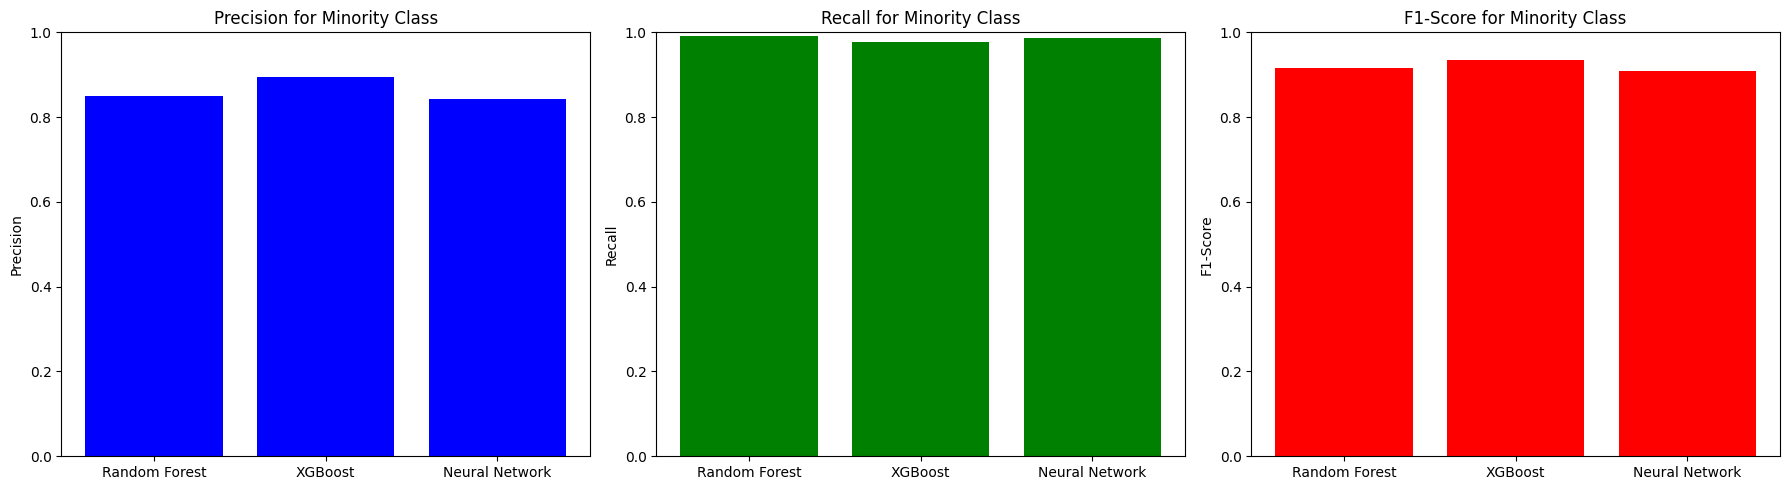

In [40]:
# Plotting the metrics for comparison
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Precision
ax[0].bar(metrics_df['Model'], metrics_df['Precision'], color='blue')
ax[0].set_title('Precision for Minority Class')
ax[0].set_ylim([0, 1])
ax[0].set_ylabel('Precision')

# Recall
ax[1].bar(metrics_df['Model'], metrics_df['Recall'], color='green')
ax[1].set_title('Recall for Minority Class')
ax[1].set_ylim([0, 1])
ax[1].set_ylabel('Recall')

# F1-Score
ax[2].bar(metrics_df['Model'], metrics_df['F1-Score'], color='red')
ax[2].set_title('F1-Score for Minority Class')
ax[2].set_ylim([0, 1])
ax[2].set_ylabel('F1-Score')

plt.tight_layout()
plt.show()

# 10.Save the Best Models

In [42]:
# Save the best Random Forest model
joblib.dump(best_rf_model, '/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/best_random_forest_model.pkl')
print("Saved the best Random Forest model as 'best_random_forest_model.pkl'")

# Save the best XGBoost model
joblib.dump(best_xgb_model, '/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/best_xgboost_model.pkl')
print("Saved the best XGBoost model as 'best_xgboost_model.pkl'")

# Save the best Neural Network model in the native Keras format
best_nn_model.model_.save('/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/best_neural_network_model.keras')
print("Saved the best Neural Network model as 'best_neural_network_model.keras'")


Saved the best Random Forest model as 'best_random_forest_model.pkl'
Saved the best XGBoost model as 'best_xgboost_model.pkl'
Saved the best Neural Network model as 'best_neural_network_model.keras'


#11.Ensemble Model(Voting Classifier)

In [43]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the base models with their best configurations
best_rf_model = halving_random_search_rf.best_estimator_  # Random Forest
best_xgb_model = random_search_xgb.best_estimator_       # XGBoost
best_nn_model = random_search_nn.best_estimator_         # Neural Network (Scikeras)

# Create a VotingClassifier with soft voting
voting_clf = VotingClassifier(
    estimators=[
        ('Random Forest', best_rf_model),
        ('XGBoost', best_xgb_model),
        ('Neural Network', best_nn_model)
    ],
    voting='soft',  # Use probabilities to determine the final prediction
    n_jobs=-1
)

# Train the Voting Classifier
print("Training the Voting Classifier...")
voting_clf.fit(X_train_resampled_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_voting = voting_clf.predict(X_test_scaled)

# Evaluate the Voting Classifier
print("\nVoting Classifier Classification Report:")
print(classification_report(y_test, y_pred_voting, digits=4))

print("\nVoting Classifier Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_voting))

# Accuracy score
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print("\nVoting Classifier Accuracy:", accuracy_voting)

# Extract Metrics for Minority Class
def get_minority_class_metrics(report):
    lines = report.strip().split('\n')
    for line in lines[2:]:
        if line.strip().startswith('1 '):
            values = line.strip().split()
            precision = float(values[1])
            recall = float(values[2])
            f1_score = float(values[3])
            support = int(values[4])
            return precision, recall, f1_score, support

voting_report = classification_report(y_test, y_pred_voting, digits=4)
voting_metrics = get_minority_class_metrics(voting_report)
print("\nMinority Class Metrics (Voting Classifier):")
print(f"Precision: {voting_metrics[0]:.4f}, Recall: {voting_metrics[1]:.4f}, F1-Score: {voting_metrics[2]:.4f}")


Training the Voting Classifier...

Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9957    0.9977    131814
           1     0.8650    0.9908    0.9236      3685

    accuracy                         0.9955    135499
   macro avg     0.9324    0.9932    0.9607    135499
weighted avg     0.9961    0.9955    0.9957    135499


Voting Classifier Confusion Matrix:
[[131244    570]
 [    34   3651]]

Voting Classifier Accuracy: 0.9955424025269559

Minority Class Metrics (Voting Classifier):
Precision: 0.8650, Recall: 0.9908, F1-Score: 0.9236


# 12.Monte Carlo Simulation

Starting Monte Carlo Simulation...

Monte Carlo Simulation Results:
Mean Accuracy: 0.9955 ± 0.0004
Mean Precision: 0.8642 ± 0.0105
Mean Recall: 0.9907 ± 0.0031
Mean F1-Score: 0.9231 ± 0.0062


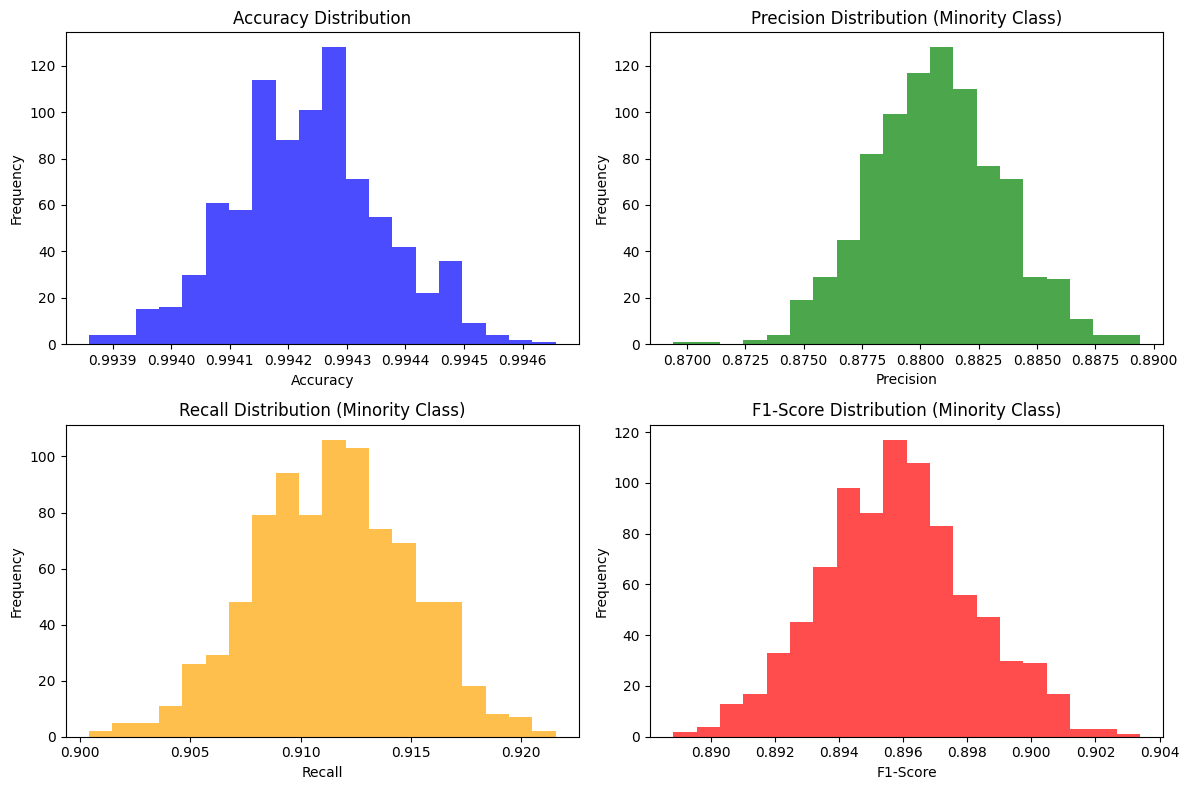


--- Best Case Scenario ---
Accuracy              0.994657
Minority_Precision    0.888685
Minority_Recall       0.918589
Minority_F1           0.903389
Name: 511, dtype: float64

--- Worst Case Scenario ---
Accuracy              0.993874
Minority_Precision    0.877546
Minority_Recall       0.900407
Minority_F1           0.888829
Name: 663, dtype: float64


In [48]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def monte_carlo_simulation(iteration, subset_ratio, model, X_test, y_test, scaler):
    sampled_indices = np.random.choice(X_test.index, size=int(len(X_test) * subset_ratio), replace=False)
    test_sample = X_test.loc[sampled_indices]
    y_sample = y_test.loc[sampled_indices]

    # Scale the test sample
    scaled_test_sample = scaler.transform(test_sample)

    # Make predictions
    y_pred = model.predict(scaled_test_sample)

    # Evaluate metrics
    accuracy = accuracy_score(y_sample, y_pred)
    report = classification_report(y_sample, y_pred, output_dict=True)
    minority_metrics = report['1']  # Metrics for the minority class
    precision = minority_metrics['precision']
    recall = minority_metrics['recall']
    f1 = minority_metrics['f1-score']

    return {
        'Accuracy': accuracy,
        'Minority_Precision': precision,
        'Minority_Recall': recall,
        'Minority_F1': f1
    }

# Run Monte Carlo Simulation in parallel
num_simulations = 500
subset_ratio = 0.2

simulation_results = Parallel(n_jobs=-1)(
    delayed(monte_carlo_simulation)(i, subset_ratio, voting_clf, X_test, y_test, scaler)
    for i in range(num_simulations)
)

# Convert results to DataFrame
simulation_df = pd.DataFrame(simulation_results)

# Summary of Results
print("\nMonte Carlo Simulation Results:")
print(f"Mean Accuracy: {np.mean(accuracy_results):.4f} ± {np.std(accuracy_results):.4f}")
print(f"Mean Precision: {np.mean(precision_results):.4f} ± {np.std(precision_results):.4f}")
print(f"Mean Recall: {np.mean(recall_results):.4f} ± {np.std(recall_results):.4f}")
print(f"Mean F1-Score: {np.mean(f1_results):.4f} ± {np.std(f1_results):.4f}")

# Visualize the results
plt.figure(figsize=(12, 8))

# Accuracy Distribution
plt.subplot(2, 2, 1)
plt.hist(simulation_df['Accuracy'], bins=20, color='blue', alpha=0.7)
plt.title('Accuracy Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')

# Precision Distribution
plt.subplot(2, 2, 2)
plt.hist(simulation_df['Minority_Precision'], bins=20, color='green', alpha=0.7)
plt.title('Precision Distribution (Minority Class)')
plt.xlabel('Precision')
plt.ylabel('Frequency')

# Recall Distribution
plt.subplot(2, 2, 3)
plt.hist(simulation_df['Minority_Recall'], bins=20, color='orange', alpha=0.7)
plt.title('Recall Distribution (Minority Class)')
plt.xlabel('Recall')
plt.ylabel('Frequency')

# F1-Score Distribution
plt.subplot(2, 2, 4)
plt.hist(simulation_df['Minority_F1'], bins=20, color='red', alpha=0.7)
plt.title('F1-Score Distribution (Minority Class)')
plt.xlabel('F1-Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Worst-case and best-case scenarios
best_case = simulation_df.loc[simulation_df['Minority_F1'].idxmax()]
worst_case = simulation_df.loc[simulation_df['Minority_F1'].idxmin()]

print("\n--- Best Case Scenario ---")
print(best_case)

print("\n--- Worst Case Scenario ---")
print(worst_case)


In [ ]:
# Save simulation summary
simulation_df.describe().to_csv('/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/monte_carlo_simulation_summary.csv')
print("Monte Carlo simulation summary saved to 'monte_carlo_simulation_summary.csv'.")

# Save feature importance
feature_importance_rf.to_csv('/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/rf_feature_importance.csv')
feature_importance_xgb.to_csv('/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/xgb_feature_importance.csv')
print("Feature importance saved for Random Forest and XGBoost.")